#0. Installing Prerequists

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

#0.1. Loading Dataset

In [3]:
print("Loading Dataset...")
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
print("Dataset for homework 2 loaded successfully!")

Loading Dataset...
Dataset for homework 2 loaded successfully!


Validating the dataset....

In [4]:
print(f"Dataset Loaded: {df.shape}")

Dataset Loaded: (9704, 11)


#0.2. Selecting the Columns

In [5]:
columns_to_use = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[columns_to_use]
print(f"Using only specified columns: {df.shape}")
print()

Using only specified columns: (9704, 5)



#1. Finding out the Column with Missing Values

In [6]:
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


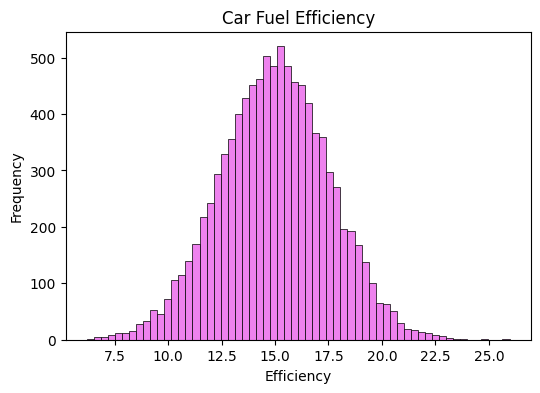

In [10]:
plt.figure(figsize=(6, 4))

sns.histplot(df.fuel_efficiency_mpg, bins=60, color='violet', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Efficiency')
plt.title('Car Fuel Efficiency')

plt.show()

In [11]:
df.describe()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
count,9704.000000,8996.000000,9704.000000,9704.000000,9704.000000
mean,199.708368,149.657292,3001.280993,2011.484027,14.985243
std,49.455319,29.879555,497.894860,6.659808,2.556468
min,10.000000,37.000000,952.681761,2000.000000,6.200971
25%,170.000000,130.000000,2666.248985,2006.000000,13.267459
50%,200.000000,149.000000,2993.226296,2012.000000,15.006037
75%,230.000000,170.000000,3334.957039,2017.000000,16.707965
max,380.000000,271.000000,4739.077089,2023.000000,25.967222


In [12]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [13]:
print("QUESTION 1: Column with missing values")
print(f"verifying the current columns{df.shape}")

missing_values = df.isnull().sum()
print("Missing values per column:")
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"  {col}: {missing_count} missing values")

QUESTION 1: Column with missing values
verifying the current columns(9704, 5)
Missing values per column:
  horsepower: 708 missing values


#2. The median (50% percentile) for variable 'horsepower'

In [14]:
df['horsepower'].describe()

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64

In [15]:
df['horsepower'].median()

np.float64(149.0)

In [16]:
median_horsepower = df['horsepower'].median()
print(f"The median (50% percentile) for variable 'horsepower' is: {median_horsepower}")

The median (50% percentile) for variable 'horsepower' is: 149.0


#0.3. Splitting datasets, and creating helper functions for further questions

Split the Datasets

In [17]:
# Shuffle the data with seed 42
np.random.seed(42)
n = len(df)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx].reset_index(drop=True)

# Calculate split sizes
n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - n_train - n_val

# Split the data
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

print(f"Train set: {len(df_train)} rows")
print(f"Validation set: {len(df_val)} rows")
print(f"Test set: {len(df_test)} rows")

# Separate the target variable
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

# Remove target from features
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

print("Data split complete!")


Train set: 5822 rows
Validation set: 1940 rows
Test set: 1942 rows
Data split complete!


Helper Functions!

In [18]:
def train_model(X, y):
    # Add ones for bias
    ones = np.ones(X.shape[0])
    X_with_bias = np.column_stack([ones, X])

    # Normal equation: w = (X^T X)^-1 X^T y
    XTX = X_with_bias.T.dot(X_with_bias)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X_with_bias.T).dot(y)

    bias = w_full[0]
    weights = w_full[1:]
    return bias, weights

def train_model_regularized(X, y, r):
    # Add ones for bias
    ones = np.ones(X.shape[0])
    X_with_bias = np.column_stack([ones, X])

    # Ridge regression: w = (X^T X + r*I)^-1 X^T y
    XTX = X_with_bias.T.dot(X_with_bias)
    regularization = r * np.eye(XTX.shape[0])
    XTX_reg = XTX + regularization
    XTX_inv = np.linalg.inv(XTX_reg)
    w_full = XTX_inv.dot(X_with_bias.T).dot(y)

    bias = w_full[0]
    weights = w_full[1:]
    return bias, weights

def predict(X, bias, weights):
    return bias + X.dot(weights)

def rmse(y_true, y_pred):
    mse = ((y_true - y_pred) ** 2).mean()
    return np.sqrt(mse)

#3 Missing Values using either 0's or mean values, & train Linear regression without regularization. Validate and compare RMSE of each option

In [21]:
# Option 1: Fill with 0
print("Testing Option 1: Fill missing values with 0")
X_train_0 = df_train.fillna(0).values
X_val_0 = df_val.fillna(0).values

bias_0, weights_0 = train_model(X_train_0, y_train)
pred_0 = predict(X_val_0, bias_0, weights_0)
rmse_0 = rmse(y_val, pred_0)

print(f"  RMSE = {round(rmse_0, 2)}")

# Option 2: Fill with mean
print("Testing Option 2: Fill missing values with mean")
mean_value = df_train['horsepower'].mean()
print(f"  Mean from training data = {mean_value:.2f}")

X_train_mean = df_train.fillna(mean_value).values
X_val_mean = df_val.fillna(mean_value).values

bias_mean, weights_mean = train_model(X_train_mean, y_train)
pred_mean = predict(X_val_mean, bias_mean, weights_mean)
rmse_mean = rmse(y_val, pred_mean)

print(f"  RMSE = {round(rmse_mean, 2)}")

# Finally Compare The results
print("RESULTS:")
print(f"  RMSE with 0:    {round(rmse_0, 2)}")
print(f"  RMSE with mean: {round(rmse_mean, 2)}")

if round(rmse_0, 2) < round(rmse_mean, 2):
    answer_q3 = "With 0 values is good rmse value"
elif round(rmse_0, 2) > round(rmse_mean, 2):
    answer_q3 = "With mean is good rmse value"
else:
    answer_q3 = "Both are equally getting good rmse value"

print(f"Answer Q3: {answer_q3}")

Testing Option 1: Fill missing values with 0
  RMSE = 0.52
Testing Option 2: Fill missing values with mean
  Mean from training data = 149.54
  RMSE = 0.46
RESULTS:
  RMSE with 0:    0.52
  RMSE with mean: 0.46
Answer Q3: With mean is good rmse value


#4. Regularized Linear Regression

In [22]:
# Fill with 0 as instructed
X_train = df_train.fillna(0).values
X_val = df_val.fillna(0).values

# Try different r values
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_results = {}

print("Testing different r values:")

for r in r_list:
    bias, weights = train_model_regularized(X_train, y_train, r)
    pred = predict(X_val, bias, weights)
    score = rmse(y_val, pred)
    rmse_results[r] = round(score, 2)
    print(f"  r = {r:>6}  -->  RMSE = {round(score, 2)}")

# Find best r
best_r = min(rmse_results, key=rmse_results.get)

print(f"Best r value: {best_r}")
print(f"Best RMSE: {rmse_results[best_r]}")
print(f"Answer Q4: {best_r}")

Testing different r values:
  r =      0  -->  RMSE = 0.52
  r =   0.01  -->  RMSE = 0.52
  r =    0.1  -->  RMSE = 0.52
  r =      1  -->  RMSE = 0.52
  r =      5  -->  RMSE = 0.52
  r =     10  -->  RMSE = 0.52
  r =    100  -->  RMSE = 0.52
Best r value: 0
Best RMSE: 0.52
Answer Q4: 0


Since all r values give RMSE = 0.52, hence choosing r = 0 (as it was the smallest value).

#5. Try with different seed values.

In [23]:
seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Store RMSE for each seed
rmse_scores = []

# Calculate split sizes (60/20/20)
n = len(df)
n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - n_train - n_val

print("Testing each seed:")
print("-"*60)

# Try each seed
for seed in seed_list:
    # Shuffle with this seed
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx].reset_index(drop=True)

    # Split the data
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()

    # Separate target variable
    y_train = df_train['fuel_efficiency_mpg'].values
    y_val = df_val['fuel_efficiency_mpg'].values

    # Remove target from features
    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']

    # Fill missing values with 0
    X_train = df_train.fillna(0).values
    X_val = df_val.fillna(0).values

    # Train model without regularization (r=0)
    bias, weights = train_model(X_train, y_train)

    # Make predictions
    predictions = predict(X_val, bias, weights)

    # Calculate RMSE
    score = rmse(y_val, predictions)
    rmse_scores.append(score)

    print(f"  Seed {seed}: RMSE = {score:.3f}")

# Calculate standard deviation
std_dev = np.std(rmse_scores)

print("RMSE scores for all seeds:")
print(f"  {[round(s, 3) for s in rmse_scores]}")
print(f"Standard deviation: {round(std_dev, 3)}")
print(f"Answer Q5: {round(std_dev, 3)}")


Testing each seed:
------------------------------------------------------------
  Seed 0: RMSE = 0.521
  Seed 1: RMSE = 0.522
  Seed 2: RMSE = 0.523
  Seed 3: RMSE = 0.516
  Seed 4: RMSE = 0.511
  Seed 5: RMSE = 0.529
  Seed 6: RMSE = 0.532
  Seed 7: RMSE = 0.510
  Seed 8: RMSE = 0.515
  Seed 9: RMSE = 0.513
RMSE scores for all seeds:
  [np.float64(0.521), np.float64(0.522), np.float64(0.523), np.float64(0.516), np.float64(0.511), np.float64(0.529), np.float64(0.532), np.float64(0.51), np.float64(0.515), np.float64(0.513)]
Standard deviation: 0.007
Answer Q5: 0.007


#6. Split the dataset using seed 9

In [24]:
# Shuffle with seed 9
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx].reset_index(drop=True)

# Split into train, val, and test
df_train_9 = df_shuffled.iloc[:n_train].copy()
df_val_9 = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test_9 = df_shuffled.iloc[n_train+n_val:].copy()

print(f"Train set: {len(df_train_9)} rows")
print(f"Val set: {len(df_val_9)} rows")
print(f"Test set: {len(df_test_9)} rows")

# Combine train and validation
df_full_train = pd.concat([df_train_9, df_val_9]).reset_index(drop=True)
print(f"Combined train+val: {len(df_full_train)} rows")

# Separate target variable
y_full_train = df_full_train['fuel_efficiency_mpg'].values
y_test = df_test_9['fuel_efficiency_mpg'].values

# Remove target from features
del df_full_train['fuel_efficiency_mpg']
del df_test_9['fuel_efficiency_mpg']

# Fill missing values with 0
X_full_train = df_full_train.fillna(0).values
X_test = df_test_9.fillna(0).values

# Train model with r=0.001
print("Training model with regularization r=0.001...")
bias, weights = train_model_regularized(X_full_train, y_full_train, r=0.001)

# Make predictions on test set
predictions_test = predict(X_test, bias, weights)

# Calculate RMSE on test set
rmse_test = rmse(y_test, predictions_test)

print(f"RMSE on test set: {rmse_test:.3f}")
print(f"Rounded to 2 decimals: {round(rmse_test, 2)}")
print(f"Answer Q6: {round(rmse_test, 2)}")


Train set: 5822 rows
Val set: 1940 rows
Test set: 1942 rows
Combined train+val: 7762 rows
Training model with regularization r=0.001...
RMSE on test set: 0.516
Rounded to 2 decimals: 0.52
Answer Q6: 0.52
